In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Data Preparation

After loading we first prepare the data by factorizing the text fields

In [2]:
kdd_data_full = pd.read_csv("./kddcup.data_10_percent_corrected", header=None)
kdd_data_full.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
kdd_data_full[1], protocols = pd.factorize(kdd_data_full[1])
kdd_data_full[2], services = pd.factorize(kdd_data_full[2])
kdd_data_full[3], flags    = pd.factorize(kdd_data_full[3])
kdd_data_full[41], attacks = pd.factorize(kdd_data_full[41])

data_full = kdd_data_full.iloc[:,:kdd_data_full.shape[1]-1]
labels_full = kdd_data_full.iloc[:,-1]

In [4]:
print(labels_full.unique())
print(len(labels_full.unique()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
23


## Determine optimal k

We decided to use the Elbow Method to determine which K is the best for representing the number of clusters therefore we are iterating through a range of clusters.
The full result is shown in the picture below.
From this we infer the optimal k is at 4.

In [5]:
def find_k(data):
    kmeans_results = []
    error = []
    labels = []
    K = range(1,30)
    for k in K:
        km = KMeans(n_clusters=k).fit(data)
        kmeans_results.append(km)
        error.append(km.inertia_)
        labels.append(km.labels_)

    plt.plot(K, error, 'o-')
    plt.xlabel('number of clusters k')
    plt.ylabel('Inertia (sum of squared distances)')
    plt.title('Optimal k')
    plt.show()

    return kmeans_results, error, labels

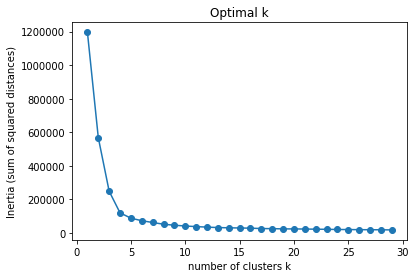

In [6]:
scaler = MinMaxScaler()
data_scaled_full = scaler.fit_transform(data_full)
kmeans_results_full, error_full, labels_full = find_k(data_scaled_full)

## Test with subset of data

We also applied this method also to the smaller subset of the data. Since this lead to the same results we decided to use the 10 percent data set for the remaining tasks. 

In [7]:
import gzip

with gzip.open('./kddcup.data_10_percent.gz') as f:
    kdd_data = pd.read_csv(f, header=None)

kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data[1], drop_first=True)], axis=1)
kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data[2], drop_first=True)], axis=1)
kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data[3], drop_first=True)], axis=1)

true_labels = kdd_data[41]
kdd_data = kdd_data.drop(columns=[1,2,3,41])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(kdd_data)
print (data_scaled.shape)

(494021, 115)


## Visualization

To visualize the clusters in a scatter plot we first transformed the data via PCA to be 3 dimensional. We can see that the 4 clusters seem to seperate the data the best of all the results we have.

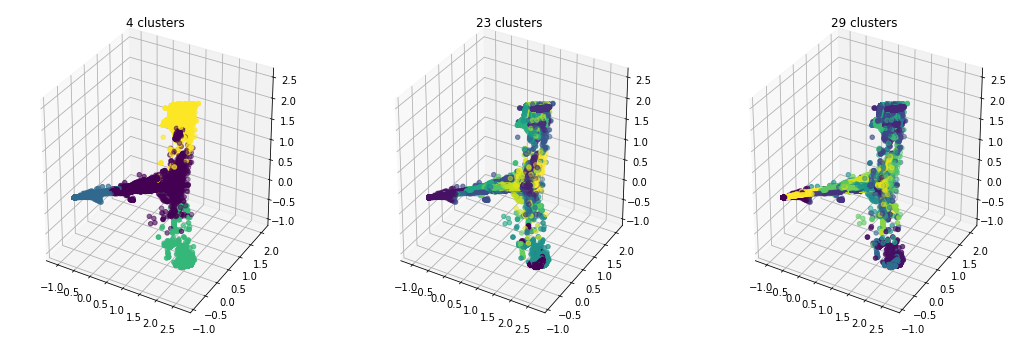

In [8]:
pca = PCA(n_components=3).fit(data_scaled)
pca_3d = pca.transform(data_scaled)

fig = plt.figure(figsize=(18, 6))
selected_labels = [labels_full[3], labels_full[22], labels_full[28]]
for index, label in enumerate(selected_labels):
    ax = fig.add_subplot(1,3, index+1, projection='3d')
    cluster_num = max(label)
    ax.set_title("{} clusters".format(cluster_num+1))
    ax.scatter(pca_3d[:,0],pca_3d[:,1], pca_3d[:,2], c=label)
plt.show()

## Dimensionality Reduction

Furthermore we attempt to reduce the dimensionality before clustering. First to speed up the computation and second to see if there are any differences in the results. We determine the number of principal components in such a way that the kept components explain 99% of the variance. In the end we reduced the number of dimensions from 41 features to 9 components.

(494021, 115) dimensions reduced to (494021, 18) dimensions


Text(0, 0.5, 'cumulative explained variance')

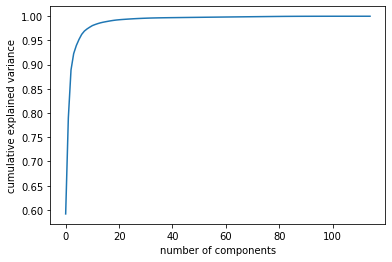

In [10]:
pca = PCA(n_components = 0.99)
pca.fit(data_scaled)
data_pca = pca.transform(data_scaled)
print("{} dimensions reduced to {} dimensions".format(data_scaled.shape, data_pca.shape))

pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

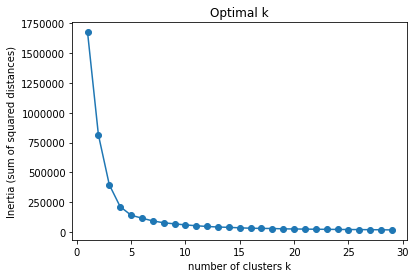

In [14]:
kmeans_results_pca, error_pca, labels_pca = find_k(data_pca)

The Elbow again is at point 4. So PCA didn't lose much information here.

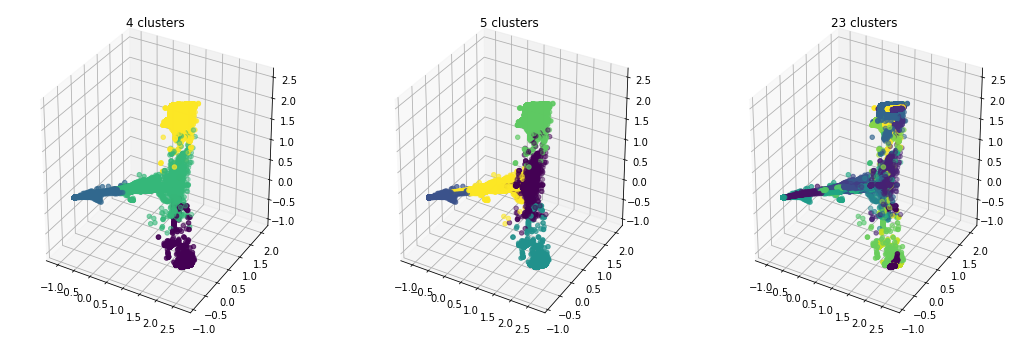

In [15]:
fig = plt.figure(figsize=(18, 6))
labels_selected = [labels_pca[3], labels_pca[4], labels_pca[22]]
for index, label in enumerate(labels_selected):
    ax = fig.add_subplot(1,3, index+1, projection='3d')
    cluster_number = max(label)+1
    ax.set_title("{} clusters".format(cluster_number))
    ax.scatter(data_pca[:,0],data_pca[:,1], data_pca[:,2], c=label)
plt.show()

In [36]:
distances = []
for index,data in enumerate(data_pca):
    cluster = kmeans_results_pca[22].labels_[index]
    dist = np.linalg.norm(data - kmeans_results_pca[22].cluster_centers_[cluster])
    distances.append(dist)

distances = sorted(distances)
median = np.median(distances)
average = np.average(distances)
threshold = max(distances) - 1
print ('median'+str(median))
print ('average'+str(average))
print ('threshold'+str(threshold))

median0.001480493265935337
average0.09490923713214959
threshold1.4188593084728471


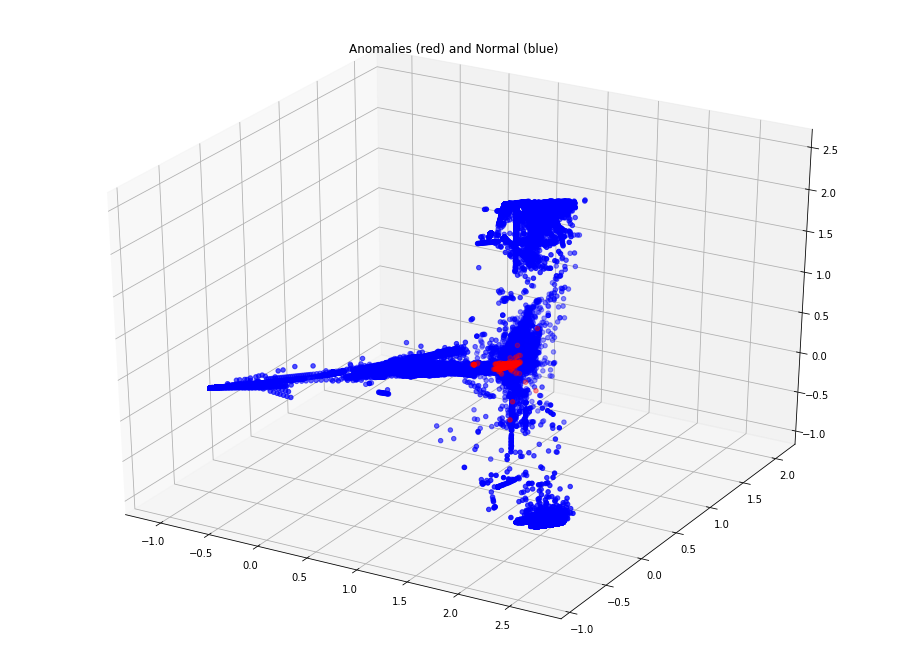

In [37]:
fig = plt.figure(figsize=(16, 12))
color_labels = []
anomalies_idx = []
normal_idx = []
for index,data in enumerate(data_pca):
    if distances[index] > threshold:
        anomalies_idx.append(index)
        color = 'r'
    else:
        color = 'b'
        normal_idx.append(index)
    color_labels.append(color)
 
ax = fig.add_subplot(111, projection='3d')
ax.set_title("Anomalies (red) and Normal (blue)")
ax.scatter(data_pca[:,0],data_pca[:,1], data_pca[:,2], c=color_labels)
plt.show()

In [38]:
true_anomalies = list(filter(lambda l: l!= 'normal.', true_labels))
true_normal = list(filter(lambda l: l == 'normal.', true_labels))
correct_labelled_normal = list(filter(lambda l: l=='normal.', true_labels[normal_idx]))
correct_labelled_anomalies = list(filter(lambda l: l!='normal.', true_labels[anomalies_idx]))
print("true normal: {:,}".format(len(true_normal)))
print("true anomalies: {:,}".format(len(true_anomalies)))
print("identified normal: {:,}".format(len(normal_idx)))
print("identified anomalies: {:,}".format(len(anomalies_idx)))
print("correctly identified normal labels num: {} ({:%})".format(len(correct_labelled_normal), len(correct_labelled_normal)/len(true_normal)))
print("correctly identified anomalies labels num: {:,} ({:%})".format(len(correct_labelled_anomalies), len(correct_labelled_anomalies)/len(true_anomalies)))

true normal: 97,278
true anomalies: 396,743
identified normal: 493,317
identified anomalies: 704
correctly identified normal labels num: 96574 (99.276301%)
correctly identified anomalies labels num: 0 (0.000000%)


## Evaluation

First we load the test data set from the KDD99 set:

In [ ]:
kdd_data_test = pd.read_csv('kd99_test.data', header=None)

print(kdd_data_test.head())

kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data_test[1], drop_first=True)], axis=1)
kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data_test[2], drop_first=True)], axis=1)
kdd_data = pd.concat([kdd_data, pd.get_dummies(kdd_data_test[3], drop_first=True)], axis=1)


true_labels_test = kdd_data_test[41]
kdd_data_test = kdd_data_test.drop(columns=[1,2,3,41])
kdd_data_test
scaler = MinMaxScaler()
data_scaled_test = scaler.fit_transform(kdd_data_test)

Then we take a block out of that data and test if they get categorized correctly

In [ ]:
km_test = KMeans(n_clusters=110).fit(data_pca)

In [ ]:
distances = []
for index,data in enumerate(data_pca):
    cluster = km_test.labels_[index]
    dist = np.linalg.norm(data - km_test.cluster_centers_[cluster])
    distances.append(dist)

distances = sorted(distances)
median_110 = np.median(distances)
average_110 = np.average(distances)
threshold_110 = max(distances) - 0.5
print("median: ", median_110)
print("average: ", average_110)
print("threshold_110: ", threshold_110)

In [ ]:
test_range = (0, 2500)
test_block_labels = true_labels_test[test_range[0]:test_range[1]]
test_block = data_scaled_test[test_range[0]:test_range[1]]
pca_test = PCA(n_components=0.99)
pca_test.fit(test_block)
pca_test_block = pca_test.transform(test_block)
k4_means = km_test 
correct_anomalies = []
incorrect_anomalies = []
correct_normal = []
incorrect_normal = []
print(median_110)
for index,data in enumerate(pca_test_block):
    idx = index + test_range[0]
    distance= min([np.linalg.norm(data-c) for c in k4_means.cluster_centers_])
    if index == 0:
        print(distance)
    if distance > median_110 and test_block_labels[idx] != 'normal.':
        correct_anomalies.append(data)
    if distance > median_110 and test_block_labels[idx] == 'normal.':
        incorrect_anomalies.append(data)
    if distance <= median_110 and test_block_labels[idx] == 'normal.':
        correct_normal.append(data)
    if distance <= median_110 and test_block_labels[idx] != 'normal.':
        incorrect_normal.append(data)

print('correct anomalies: ', len(correct_anomalies))
print('incorrect anomalies: ', len(incorrect_anomalies))
print('correct normals: ', len(correct_normal))
print('incorrect normals: ', len(incorrect_normal))
print('total number of anomalies', len([l for l in test_block_labels if l != 'normal.']))
print('total number of normal', len([l for l in test_block_labels if l == 'normal.']))
TP = len(correct_anomalies)
TN = len(correct_normal)
FN = len(incorrect_normal)
FP = len(incorrect_anomalies)

In [ ]:
precision = TP/(TP + FP)
print('precision', precision)
recall = TP/(TP+FN)
print('recall', recall)
false_positive_rate = FP/(FP+TN)
print('false positive rate', false_positive_rate)
specifity = TN / (FP + TN)
print('specifity ', specifity)
negative_predictive_value = TN/ (TN + FN + 0.00001)
print('negative predictive value ', negative_predictive_value)
accuracy = (TP+TN) / (TP+FP+FN+TN)
print('accuracy', accuracy)
F1 = 2 * (precision * recall) / (precision + recall)
print("F1 score ", F1)